<a href="https://colab.research.google.com/github/pdhimate/Azure-Automation/blob/master/assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SIT744 Assignment 2: Efficient Training of Convolutional Neural Network 

<div class="alert-info">
    <p>Due: <strong>11:59pm 29 September 2020</strong>  (Tuesday)</p>

This is an <strong>individual</strong> assignment. It contributes <strong>45%</strong> to your final mark. Read the assignment instruction carefully.

<h2> What to submit </h2>

<p>
This assignment is to be completed individually and submitted to CloudDeakin. <strong>By the due date, you are required to submit the following files to the corresponding Assignment (Dropbox) in CloudDeakin</strong>:

<ol>
<li>	<strong>[YourID]_assignment2_solution.ipynp</strong>:  This is your Python notebook solution source file. </li>
<li>	<strong>[YourID]_assingment2_output.html</strong>: This is the output of your Python notebook solution <emph>exported</emph> in HTML format.</li>
<li>	Extra files needed to complete your assignment, if any (e.g., images used in your answers).</li>
</ol>
</p>

<p>
For example, if your student ID is: 123456, you will then need to submit the following files:
<ul>
<li> 123456_assignment2_solution.ipynp </li>
<li> 123456_assignment2_output.html</li>
</ul>
</p>

<h2> Warning </h2>

Some components of this assignment may involve heavy computation that runs for a long duration. Please start early to avoid missing the assignment due date.

<h2> Marking criteria </h2>

<p>
Your submission will be marked using the following criteria.

<ul>
<li> Showing good effort through completed tasks.</li>
<li> Applying deep learning theory to design suitable deep learning solutions for the tasks.</li>
<li> Critically evaluating and reflecting on the pros and cons of various design decisions.</li>
<li> Demonstrating creativity and resourcefulness in providing unique individual solutions.</li>
<li> Showing attention to details through a good quality assignment report.</li>
</ul>
</p>

<p>
Indicative weights of various tasks are provided, but the assignment will be marked by the overall quality per the above criteria.
</p>
</div>

## Assignment objective

This assignment is to feedback on your learning in deep learning theory and its application to  data analytics or artificial intelligence problems.  

It builds on Assignment 1 but requires a higher level of mastery of deep learning theory and programming/engineering skills. In particular, you will experience training a much deeper network on a large-scale dataset. You will encounter  practical issues that help you consolidate textbook learning. 

In [1]:
# Note: All the packages required have been imported here for simplicity of code latter

# Tensorflow packages
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets  as tfds
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import plot_model, to_categorical
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# tensorflow profiler
!pip install -U tensorboard_plugin_profile

# other helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import math
from datetime import datetime
from packaging import version
import os

# Some commonly used helper functions are defined here for ease of usage in future code blocks
def plot_accuracy_loss(train_ac, val_ac, train_loss, val_loss):
  # Plot Epoch vs Accuracy metric values
  plt.plot(train_ac, label='training accuracy')
  plt.plot(val_ac, label = 'validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  # Plot Epoch vs loss values
  plt.plot(train_loss, label = 'training loss')
  plt.plot(val_loss, label = 'validation loss')
  plt.title('Model loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# spilts the specified dataset into 2 parts
def split_data(dataset, target_percent=0.1):
  dataset_len = len(dataset)
  percent = 1 - target_percent;
  old_dataset = dataset[0:int(dataset_len*percent)] # e.g. 1 to 90% train
  new_dataset = dataset[int(dataset_len*percent):] # e.g. 91 to 100% remaining
  return old_dataset, new_dataset


Requirement already up-to-date: tensorboard_plugin_profile in /usr/local/lib/python3.6/dist-packages (2.3.0)


## Task 1 Solving Fashion-MNIST with Convolutional Neural Networks

*(weight ~10%)*

In Assignment 1, you tackled the image classification problem in Fashion-MNIST. There, you used a Densely Connected Neural Network. You should now know that is not an optimal model architecture for the problem. In Assignment 2, you will apply the best practices of deep-learning computer vision to improve the image classification performance.

### Task 1.1 Revisit Fashion-MNIST classification with DNN

*(weight ~2%)*

Review your Assignment 1 solution, and reproduce the experiment here. Try to improve the model without changing the model architecture.


In [2]:
# def stratified_split(train_data, train_labels, test_data, test_labels):
#   combined = np.concatenate((train_data,test_data))
#   dataset =tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(combined))
#   size = len(dataset)
#   print("Dataset size: ", size)
#   train_size = int(0.7 * size)
#   val_size = int(0.15 * size)
#   test_size = int(0.15 * size)

#   unique_labels = tf.unique(train_labels).y
#   print("unique labels: ", unique_labels)
#   full_dataset = dataset.shuffle(buffer_size=100)
#   train_dataset = dataset.take(train_size)
#   test_dataset = dataset.skip(train_size)
#   val_dataset = test_dataset.skip(val_size)
#   test_dataset = test_dataset.take(test_size)
#   return train_dataset, test_dataset, val_dataset

# (train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()
# train, test, val = stratified_split(train_images,train_labels, test_images, test_labels)
# print("Split complete")
# print(len(train))
# print(len(test))
# print(len(val))

# for d in val.take(1):
#   print(d.slice())

In [3]:
# Prepare dataset
print("Prepare fashion MNIST dataset as we did in assignment 1.") 
(fm_train_images, fm_train_labels), (fm_test_images, fm_test_labels) = keras.datasets.fashion_mnist.load_data()

# Scale and reshape the dataset
fm_train_images_scaled = fm_train_images.astype('float64') / 255.0 
fm_test_images_scaled = fm_test_images.astype('float64') / 255.0
fm_train_images_scaled_reshaped = tf.reshape(fm_train_images_scaled,(60000, 28 , 28, 1))
fm_test_images_scaled_reshaped = tf.reshape(fm_test_images_scaled,(10000, 28 , 28, 1))

# Set validation dataset
fm_val_data = fm_train_images_scaled_reshaped[-10000:]
fm_val_labels = fm_train_labels[-10000:]
# Remove validation data from traning data frames
fm_train_images_scaled_reshaped_noval = fm_train_images_scaled_reshaped[:-10000]
fm_train_labels_noval = fm_train_labels[:-10000]

# Create input pipeline with a predefined batch size
def create_pipeline(data, labels):
    pipeline = tf.data.Dataset.from_tensor_slices((data,labels))
    pipeline = pipeline.shuffle(buffer_size = 100) # shuffle the data
    pipeline = pipeline.batch(batch_size = 250) # Set batch size in the Dataset/Pipe 
    return pipeline

# Apply one hot encoding for the labels
fm_train_labels_noval_enc = to_categorical(fm_train_labels_noval)  
fm_test_labels_enc = to_categorical(fm_test_labels)
fm_val_labels_enc = to_categorical(fm_val_labels)

# Create Training pipeline
fm_train_labels_tensor = tf.convert_to_tensor(fm_train_labels_noval_enc, np.int32)
fm_train_pipe = create_pipeline(fm_train_images_scaled_reshaped_noval, fm_train_labels_tensor)

# Create Validation pipeline
fm_val_labels_tensor = tf.convert_to_tensor(fm_val_labels_enc, np.int32)
fm_val_pipe = create_pipeline(fm_val_data, fm_val_labels_tensor)

print("Dataset is encoded and pipelined now.")

Prepare fashion MNIST dataset as we did in assignment 1.
Dataset is encoded and pipelined now.


In [4]:
def create_tuned_neuralnetwork_model_assign1(dropout, enableBatchNorm, weight_regularizer):
    m = tf.keras.models.Sequential()

    if (enableBatchNorm == True):
      m.add(layers.BatchNormalization(input_shape=(28,28,1)))
      m.add(layers.Conv2D(filters=32,kernel_size=3,activation='relu'))
    else:
      m.add(layers.Conv2D(filters=32,kernel_size=3,activation='relu', input_shape=(28,28,1)))

    m.add(layers.MaxPooling2D(pool_size=2)) # down sampling the output instead of 28*28 it is 14*14 
    m.add(layers.Flatten()) # flatten the layers
    m.add(layers.Dropout(dropout)) # add dropout
    m.add(layers.Dense(32, activation='relu',
                       kernel_regularizer=weight_regularizer, # we use weight regularizers 
                       bias_regularizer=weight_regularizer))  # for kernel and bias with default 0.01 value
    m.add(layers.Dense(10, activation='softmax')) # output layer
    return m

# Parameter values for tuning
print("Based on our observations in assignment 1, we select multiple parameters to try to improve our model further.")
epochs = [30, 33]  # Since we observed in previously that epoch close to 30 gave robust fit
optimizers = ['adam', 'rmsprop']
dropouts = [0.2]
learning_rates = [0.001] # This learning rate gave us best performance last time in  assignment 1
loss_functions = ['categorical_crossentropy'] # This loss function gave best performance last time in  assignment 1
batch_normalized = [True] # we will use True since it gave better performance in assignment 1
weight_regularizers = ['l2'] # we will use l2 only since it gave us better performance in assignment 1
print("Including the recomended parameters for tuning, we use the following ones:")
print("Epochs Range: ", epochs)
print("Optimizers used: ", optimizers)
print("Dropouts Range: ", dropouts)
print("Learning Rates Range: ", learning_rates)
print("Loss Functions used: ", loss_functions)
print("Batch Normalized values: ", batch_normalized)
print("Weight Regularizers used: ", weight_regularizers)

Based on our observations in assignment 1, we select multiple parameters to try to improve our model further.
Including the recomended parameters for tuning, we use the following ones:
Epochs Range:  [30, 33]
Optimizers used:  ['adam', 'rmsprop']
Dropouts Range:  [0.2]
Learning Rates Range:  [0.001]
Loss Functions used:  ['categorical_crossentropy']
Batch Normalized values:  [True]
Weight Regularizers used:  ['l2']


In [5]:
# Trying to improve the model from assignment 1 by hyperparameter optimization
print("To try to improve our model, we fine tune it for each combination of the parameters we found best in the previous assignment:")
fm_results = [] # we will note results after each run to compare latter on
batch_size = 250

print("We use GPU for faster processing.")
with tf.device('/device:GPU:0'):
  for epoch in epochs:
    for optimizer in optimizers:
      for dropout in dropouts:
        for lr in learning_rates:
          for lf in loss_functions:
            for bn in batch_normalized:
              for wr in weight_regularizers:
                print("############## Running for following parameters ###############")
                print("Epoch: ", epoch, ", Optimizer: ", optimizer, ", Dropout: ", dropout,
                      ", Learning rate: ", lr, ", Loss Function: ", lf, ", Batch Normalized: ", bn,
                      ", Weight Regularizer: ", wr)
                nn = create_tuned_neuralnetwork_model_assign1(dropout=dropout, enableBatchNorm=bn, weight_regularizer=wr)
                nn.compile(optimizer = optimizer, loss=lf, metrics=['accuracy'])
                K.set_value(nn.optimizer.learning_rate, lr)
                hist = nn.fit(fm_train_pipe, epochs = epoch,batch_size = batch_size, validation_data = fm_val_pipe, verbose=0)
                result = nn.evaluate(fm_test_images_scaled_reshaped, fm_test_labels_enc)
                print("Run complete. Test accuracy is: ", result[1])
                fm_results.append({
                    'Epoch': epoch,
                    'Optimizer': optimizer,
                    'Dropout': dropout,
                    'Learning rate': lr, 
                    'Loss Function': lf,
                    'Batch Normalized': bn,
                    'Weight Regularizer' : wr,
                    'Test Accuracy': result[1],
                    'History': hist
                })
                print("")

To try to improve our model, we fine tune it for each combination of the parameters we found best in the previous assignment:
We use GPU for faster processing.
############## Running for following parameters ###############
Epoch:  30 , Optimizer:  adam , Dropout:  0.2 , Learning rate:  0.001 , Loss Function:  categorical_crossentropy , Batch Normalized:  True , Weight Regularizer:  l2
313/313 [==============================] - 1s 2ms/step - loss: 0.3711 - accuracy: 0.8958
Run complete. Test accuracy is:  0.895799994468689

############## Running for following parameters ###############
Epoch:  30 , Optimizer:  rmsprop , Dropout:  0.2 , Learning rate:  0.001 , Loss Function:  categorical_crossentropy , Batch Normalized:  True , Weight Regularizer:  l2
313/313 [==============================] - 1s 2ms/step - loss: 0.4082 - accuracy: 0.8841
Run complete. Test accuracy is:  0.8841000199317932

############## Running for following parameters ###############
Epoch:  33 , Optimizer:  adam , 

In [6]:
# Display results   
print("")
print("All optimization/tuning runs complete. ")         
print("Below are the results of the tuning runs sorted by accuracy in descending order. ")         
fm_results_df = pd.DataFrame(fm_results).sort_values('Test Accuracy', ascending = False)
fm_results_df.iloc[:,:-1] # we ignore last column which is history. We will use it latter for plotting.


All optimization/tuning runs complete. 
Below are the results of the tuning runs sorted by accuracy in descending order. 


,Epoch,Optimizer,Dropout,Learning rate,Loss Function,Batch Normalized,Weight Regularizer,Test Accuracy
0,30,adam,0.2,0.001,categorical_crossentropy,True,l2,0.8958
2,33,adam,0.2,0.001,categorical_crossentropy,True,l2,0.8925
3,33,rmsprop,0.2,0.001,categorical_crossentropy,True,l2,0.8898
1,30,rmsprop,0.2,0.001,categorical_crossentropy,True,l2,0.8841


In [7]:
fm_best_accuracy_result = fm_results_df.iloc[[0]]


In [8]:
print("############## Improvements as compared to assignment 1 ###############")
print("We can see only minor (0.8959 vs 0.8981) or no improvement as compared to assignment 1 results.")
print("#######################################################################")

############## Improvements as compared to assignment 1 ###############
We can see only minor (0.8959 vs 0.8981) or no improvement as compared to assignment 1 results.
#######################################################################


### Task 1.2 Train a ConvNet from scratch

*(weight ~2%)*

Build a ConvNet to replace the densely connected network in Task 1.1. Report the classification accuracy on the test set. Aim to achieve higher accuracy. 



In [9]:
print("We use the more advanced Convo2D network to improve the classification accuracy.")
def create_tuned_neuralnetwork_model_assign1_convo(weight_regularizer):
    m = tf.keras.models.Sequential()
    m.add(layers.BatchNormalization(input_shape=(28,28,1)))
    m.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')) 
    m.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    m.add(tf.keras.layers.Dropout(0.3))
    m.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    m.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    m.add(tf.keras.layers.Dropout(0.3))
    m.add(tf.keras.layers.Flatten())
    m.add(tf.keras.layers.Dense(256, activation='relu'))
    m.add(tf.keras.layers.Dropout(0.5))
    m.add(tf.keras.layers.Dense(10, activation='softmax'))

    return m


We use the more advanced Convo2D network to improve the classification accuracy.


In [10]:
# Trying to improve the model from assignment 1 by convo2d 
print("To try to improve our model, we fine tune it for each combination of the parameters we found best in the previous assignment:")
fm_results_convo = [] # we will note results after each run to compare latter on
epochs = [30]  # Since we observed in previous graphs that epoch close to 30 gave robust fit
optimizers = ['adam', 'rmsprop']
learning_rates = [0.001]
loss_functions = ['categorical_crossentropy']
batch_normalized = [True] # we will use True since it gave better performance in assignment 1
weight_regularizers = ['l2'] # we will use l2 only since it gave us better performance in assignment 1

print("We use GPU for faster processing.")
with tf.device('/device:GPU:0'):
  for epoch in epochs:
    for optimizer in optimizers:
      for lr in learning_rates:
        for lf in loss_functions:
          for bn in batch_normalized:
            for wr in weight_regularizers:
              print("############## Running for following parameters ###############")
              print("Epoch: ", epoch, ", Optimizer: ", optimizer,
                    ", Learning rate: ", lr, ", Loss Function: ", lf, ", Batch Normalized: ", bn,
                    ", Weight Regularizer: ", wr)
              nn = create_tuned_neuralnetwork_model_assign1_convo(weight_regularizer=wr)
              nn.compile(optimizer = optimizer, loss=lf, metrics=['accuracy'])
              K.set_value(nn.optimizer.learning_rate, lr)
              hist = nn.fit(fm_train_pipe, epochs = epoch,batch_size = batch_size, validation_data = fm_val_pipe, verbose=0)
              result = nn.evaluate(fm_test_images_scaled_reshaped, fm_test_labels_enc)
              print("Run complete. Test accuracy is: ", result[1])
              fm_results_convo.append({
                  'Epoch': epoch,
                  'Optimizer': optimizer,
                  'Learning rate': lr, 
                  'Loss Function': lf,
                  'Batch Normalized': bn,
                  'Weight Regularizer' : wr,
                  'Test Accuracy': result[1],
                  'History': hist
              })
              print("")


To try to improve our model, we fine tune it for each combination of the parameters we found best in the previous assignment:
We use GPU for faster processing.
############## Running for following parameters ###############
Epoch:  30 , Optimizer:  adam , Learning rate:  0.001 , Loss Function:  categorical_crossentropy , Batch Normalized:  True , Weight Regularizer:  l2
313/313 [==============================] - 1s 2ms/step - loss: 0.2347 - accuracy: 0.9172
Run complete. Test accuracy is:  0.9172000288963318

############## Running for following parameters ###############
Epoch:  30 , Optimizer:  rmsprop , Learning rate:  0.001 , Loss Function:  categorical_crossentropy , Batch Normalized:  True , Weight Regularizer:  l2
313/313 [==============================] - 1s 2ms/step - loss: 0.2393 - accuracy: 0.9193
Run complete. Test accuracy is:  0.9193000197410583



In [11]:
# Display results   
print("")
print("All optimization/tuning runs for convo neural network complete. ")         
print("Below are the results of the tuning runs sorted by accuracy in descending order. ")         
fm_results_convo_df = pd.DataFrame(fm_results_convo).sort_values('Test Accuracy', ascending = False)
fm_results_convo_df.iloc[:,:-1] # we ignore last column which is history. We will use it latter for plotting.


All optimization/tuning runs for convo neural network complete. 
Below are the results of the tuning runs sorted by accuracy in descending order. 


,Epoch,Optimizer,Learning rate,Loss Function,Batch Normalized,Weight Regularizer,Test Accuracy
1,30,rmsprop,0.001,categorical_crossentropy,True,l2,0.9193
0,30,adam,0.001,categorical_crossentropy,True,l2,0.9172


Plots below help us to check overfitting or underfitting


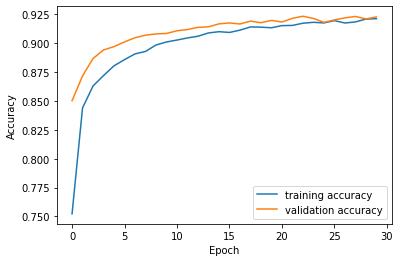

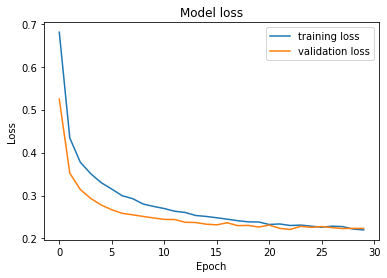

We can observe that the model is a good/robust fit around Epoch = 30 and not underfitted or overfitted.


In [12]:
print("Plots below help us to check overfitting or underfitting")

fm_best_accuracy_result_convo = fm_results_convo_df.iloc[[0]]
plot_accuracy_loss(fm_best_accuracy_result_convo['History'].values[0].history['accuracy'],
                   fm_best_accuracy_result_convo['History'].values[0].history['val_accuracy'],
                   fm_best_accuracy_result_convo['History'].values[0].history['loss'], 
                   fm_best_accuracy_result_convo['History'].values[0].history['val_loss'])
print("We can observe that the model is a good/robust fit around Epoch = 30 and not underfitted or overfitted.")

Thus, Convo2D neural network has significantly improved the accuracy upto 92%


In [13]:
fm_best_accuracy_result_convo.iloc[:,:-1]

,Epoch,Optimizer,Learning rate,Loss Function,Batch Normalized,Weight Regularizer,Test Accuracy
1,30,rmsprop,0.001,categorical_crossentropy,True,l2,0.9193


In [14]:
print("############## Improvements as compared to Task 1.1 ###############")
print("Thus the performance has improved upto 92% from 89%")
print("#######################################################################")

############## Improvements as compared to Task 1.1 ###############
Thus the performance has improved upto 92% from 89%
#######################################################################



### Task 1.3 Build an input pipeline for data augmentation

*(weight ~2%)*

Build a data preprocessing pipeline to perform data augmentation. (You may use Keras ImageDataGenerator or write your own transformations.)

- Report the new classification accuracy. Make sure that you use the same number of training epochs as in Task 1.2.

- (Optional) Profile your input pipeline to identify the most time-consuming operation. What actions have you taken to address that slow operation? (*Hint: You may use the [TensorFlow Profiler](https://github.com/tensorflow/profiler).*)

In [15]:
# Create TensorBoard callback for profiling
!rm -rf ./logs/ # clear old logs
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tboard_profiler_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520') # number fo steps to capture
print("Initialized tensor board callback for profiler.")

Initialized tensor board callback for profiler.


In [17]:
# Set validation dataset
fm_val_images = fm_train_images[-10000:]
fm_val_labels = fm_train_labels[-10000:]
# Remove validation data from traning dataset
fm_train_images_noval = fm_train_images[:-10000]
fm_train_labels_noval = fm_train_labels[:-10000]

# Reshape
fm_train_images_reshaped = tf.reshape(fm_train_images_noval,(50000, 28 , 28, 1))
fm_test_images_reshaped = tf.reshape(fm_test_images,(10000, 28 , 28, 1))
fm_val_images_reshaped = tf.reshape(fm_val_images,(10000, 28 , 28, 1))

# Apply one hot encoding for the labels
fm_train_labels_noval_enc = to_categorical(fm_train_labels_noval)  
fm_test_labels_enc = to_categorical(fm_test_labels)
fm_val_labels_enc = to_categorical(fm_val_labels)

# set parameters used in Task 1.2 (best accuracy)
epoch = 30
batch_size = 64
wr = 'l2'
optimizer = 'adam'
lf = 'categorical_crossentropy'
lr = 0.001

# helper functions to create the pipeline and augment images
def image_preprocessor(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)  # scale the image
  return image, label
# TODO: the accuracy reduced from 92 to 90, because the epoch are less (30) and the model ssems underfitted from plots.
# Check if this is right (expected). 
# Checked, accuracy must go up. Try gray scaling the images. Try augmenting validation pipeline as well.
def image_augmenter(image,label):
  image = tf.image.random_flip_left_right(image)  # horizontal flip
  #image = tf.image.random_flip_up_down(image) # vertical flip
  image = tf.image.random_brightness(image,0.2)  
  image = tf.image.random_contrast(image,0.1,0.9)  
  return image, label

# Create a pipeline with image augmentation
train_pipe = tf.data.Dataset.from_tensor_slices((fm_train_images_reshaped, fm_train_labels_noval_enc)).map(image_preprocessor)
val_pipe = tf.data.Dataset.from_tensor_slices((fm_val_images_reshaped, fm_val_labels_enc))
aug_train_pipe = (train_pipe
                  .map(image_augmenter, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                  .batch(batch_size) # batch the data so that we do not run out of RAM.
                  .repeat() # repeat so that fit does not run out of data while running a step (depending on batch size)
                  .cache() # cache to improve performance.
                  .prefetch(tf.data.experimental.AUTOTUNE)) # This was added to improve performance as checked in profiler
print("Pipeline created. Specs: ")
print("Training pipe: ", aug_train_pipe.element_spec)
print("Validation pipe: ", val_pipe.element_spec)

# Train the model using augmented pipeline
print("Training the model using the same epochs as used in Task 1.2.")
aug_network = create_tuned_neuralnetwork_model_assign1_convo(weight_regularizer=wr)
aug_network.compile(optimizer = optimizer, loss=lf, metrics=['accuracy'])
K.set_value(aug_network.optimizer.learning_rate, lr)
with tf.device('/device:GPU:0'):
  fm_aug_hist = aug_network.fit(aug_train_pipe,
                       steps_per_epoch = (50000/batch_size),
                       epochs = epoch,
                       validation_data = val_pipe,
                       validation_steps = (10000/batch_size),
                       callbacks = [tboard_profiler_callback])
# Evaluate the model
print("Model traning complete.")
fm_aug_loss, fm_aug_acc = aug_network.evaluate(fm_test_images_reshaped, fm_test_labels_enc)
print("Model evaluation complete.")

Pipeline created. Specs: 
Training pipe:  (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))
Validation pipe:  (TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(10,), dtype=tf.float32, name=None))
Training the model using the same epochs as used in Task 1.2.
Epoch 1/30
782/781 [==============================] - ETA: 0s - loss: 0.8077 - accuracy: 0.7171

ValueError: ignored

In [ ]:
# # TODO: This one works too, need to check accuracy.
# # Either use the above one or this one.
# imagedatagen = ImageDataGenerator( 
#         #rotation_range=10,        # randomly rotate between 0-rotation_range angle
#         #width_shift_range=0.2,    # randomly shift horizontally by this much
#         #height_shift_range=0.2,   # randomly shift vertically by this much
#         #shear_range=0.2,          # randomly shear by (+/- 20%)
#         #zoom_range=0.2,           # randomly zoom (80% - 120%)
#         horizontal_flip=True,     # flip the image horizontally
#         #fill_mode='nearest'       # fill any pixels lost in xform with nearest
#     )

# # fit the data generator on training data & validate on
# imagedatagen.fit(fm_train_images_scaled_reshaped_noval)
# num_train_batches = len(fm_train_images_scaled_reshaped_noval) // batch_size
# num_train_batches += (0 if len(fm_train_images_scaled_reshaped_noval) % batch_size == 0 else 1)     
# num_val_batches = len(fm_val_data) // batch_size
# num_val_batches += (0 if len(fm_val_data) % batch_size == 0 else 1)     
# num_test_batches = len(fm_test_images_scaled_reshaped) // batch_size
# num_test_batches += (0 if len(fm_test_images_scaled_reshaped) % batch_size == 0 else 1)

# # train the model with augmented images 
# fm_train_generator = imagedatagen.flow(fm_train_images_scaled_reshaped_noval, fm_train_labels_noval_enc , batch_size=batch_size, seed= 99)
# fm_val_generator = imagedatagen.flow(fm_val_data, fm_val_labels_enc , batch_size=batch_size, seed= 99)
# nn = create_tuned_neuralnetwork_model_assign1_convo(dropout=dropout, weight_regularizer=wr)
# nn.compile(optimizer = optimizer, loss=lf, metrics=['accuracy'])
# K.set_value(nn.optimizer.learning_rate, lr)
# #hist = nn.fit_generator(fm_train_generator, epochs = epoch, validation_data = fm_val_generator)

# with tf.device('/device:GPU:0'):
#   fm_aug_hist = nn.fit_generator(fm_train_generator,
#                             steps_per_epoch = num_train_batches, 
#                             epochs = epoch,
#                             validation_data = fm_val_generator,
#                             validation_steps = num_val_batches)

# fm_aug_loss, fm_aug_acc = nn.evaluate(fm_test_images_scaled_reshaped, fm_test_labels_enc)

# # fm_test_generator = image_datagen.flow(fm_test_images_reshaped, fm_test_labels_enc , batch_size=batch_size, seed= 99)
# # loss, acc = nn.evaluate_generator(fm_test_generator, 
# #                                   steps=num_test_batches,
# #                                   verbose=1)



In [ ]:
plot_accuracy_loss(fm_aug_hist.history['accuracy'],
                   fm_aug_hist.history['val_accuracy'],
                   fm_aug_hist.history['loss'], 
                   fm_aug_hist.history['val_loss'])
print("We can observe that the model seems to be underfitted around Epoch = 30. ")
print("We should use a model with more nodes or use more epochs.")

# evaluate metrics
print('Test data:', flush=True)
print("Testing  : loss %f - acc %f" % (fm_aug_loss, fm_aug_acc))

In [ ]:
print("############## Improvements as compared to Task 1.2 ###############")
print("Thus the performance has reduced upto 90% from 92%")
print("#######################################################################")

In [ ]:
print("We now open tensorboard to check profiler logs: ")
%load_ext tensorboard
%tensorboard --logdir logs

**Tensorboard images from profiling.**
1. Run 1: Here we find that the model is highly input-bound (60.5%)
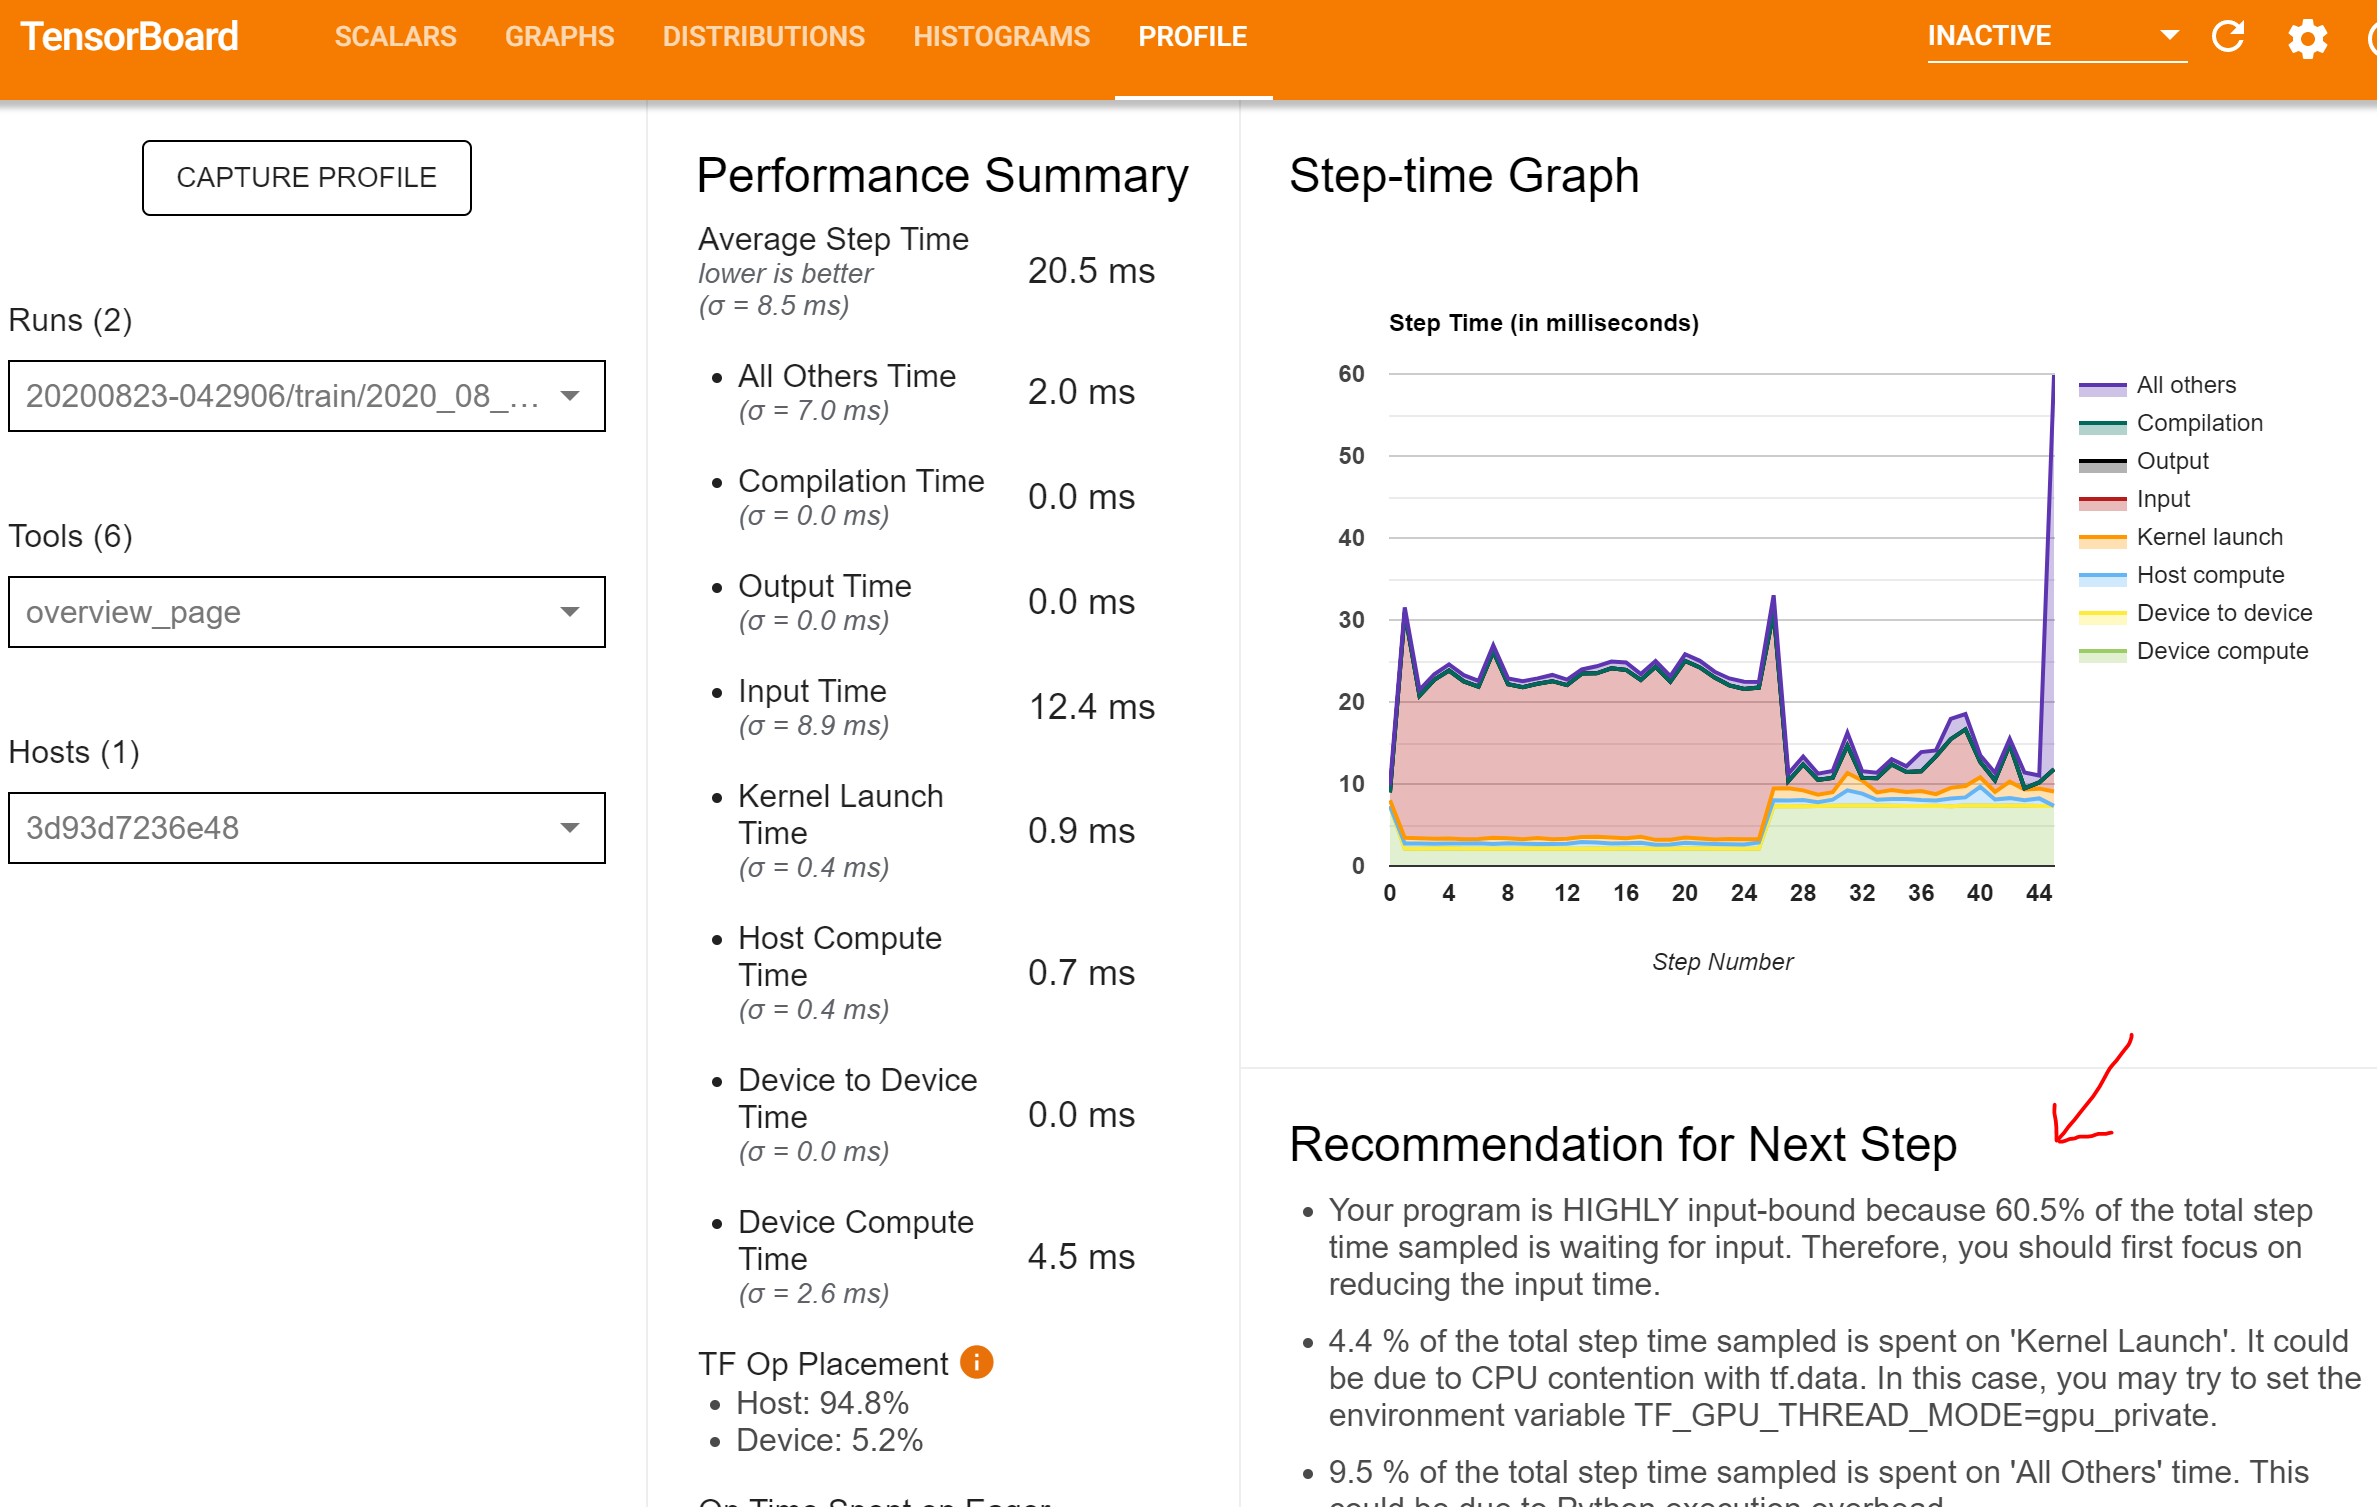

2. To reduce it, here we reduced the batch size to 200 and got 52.5%
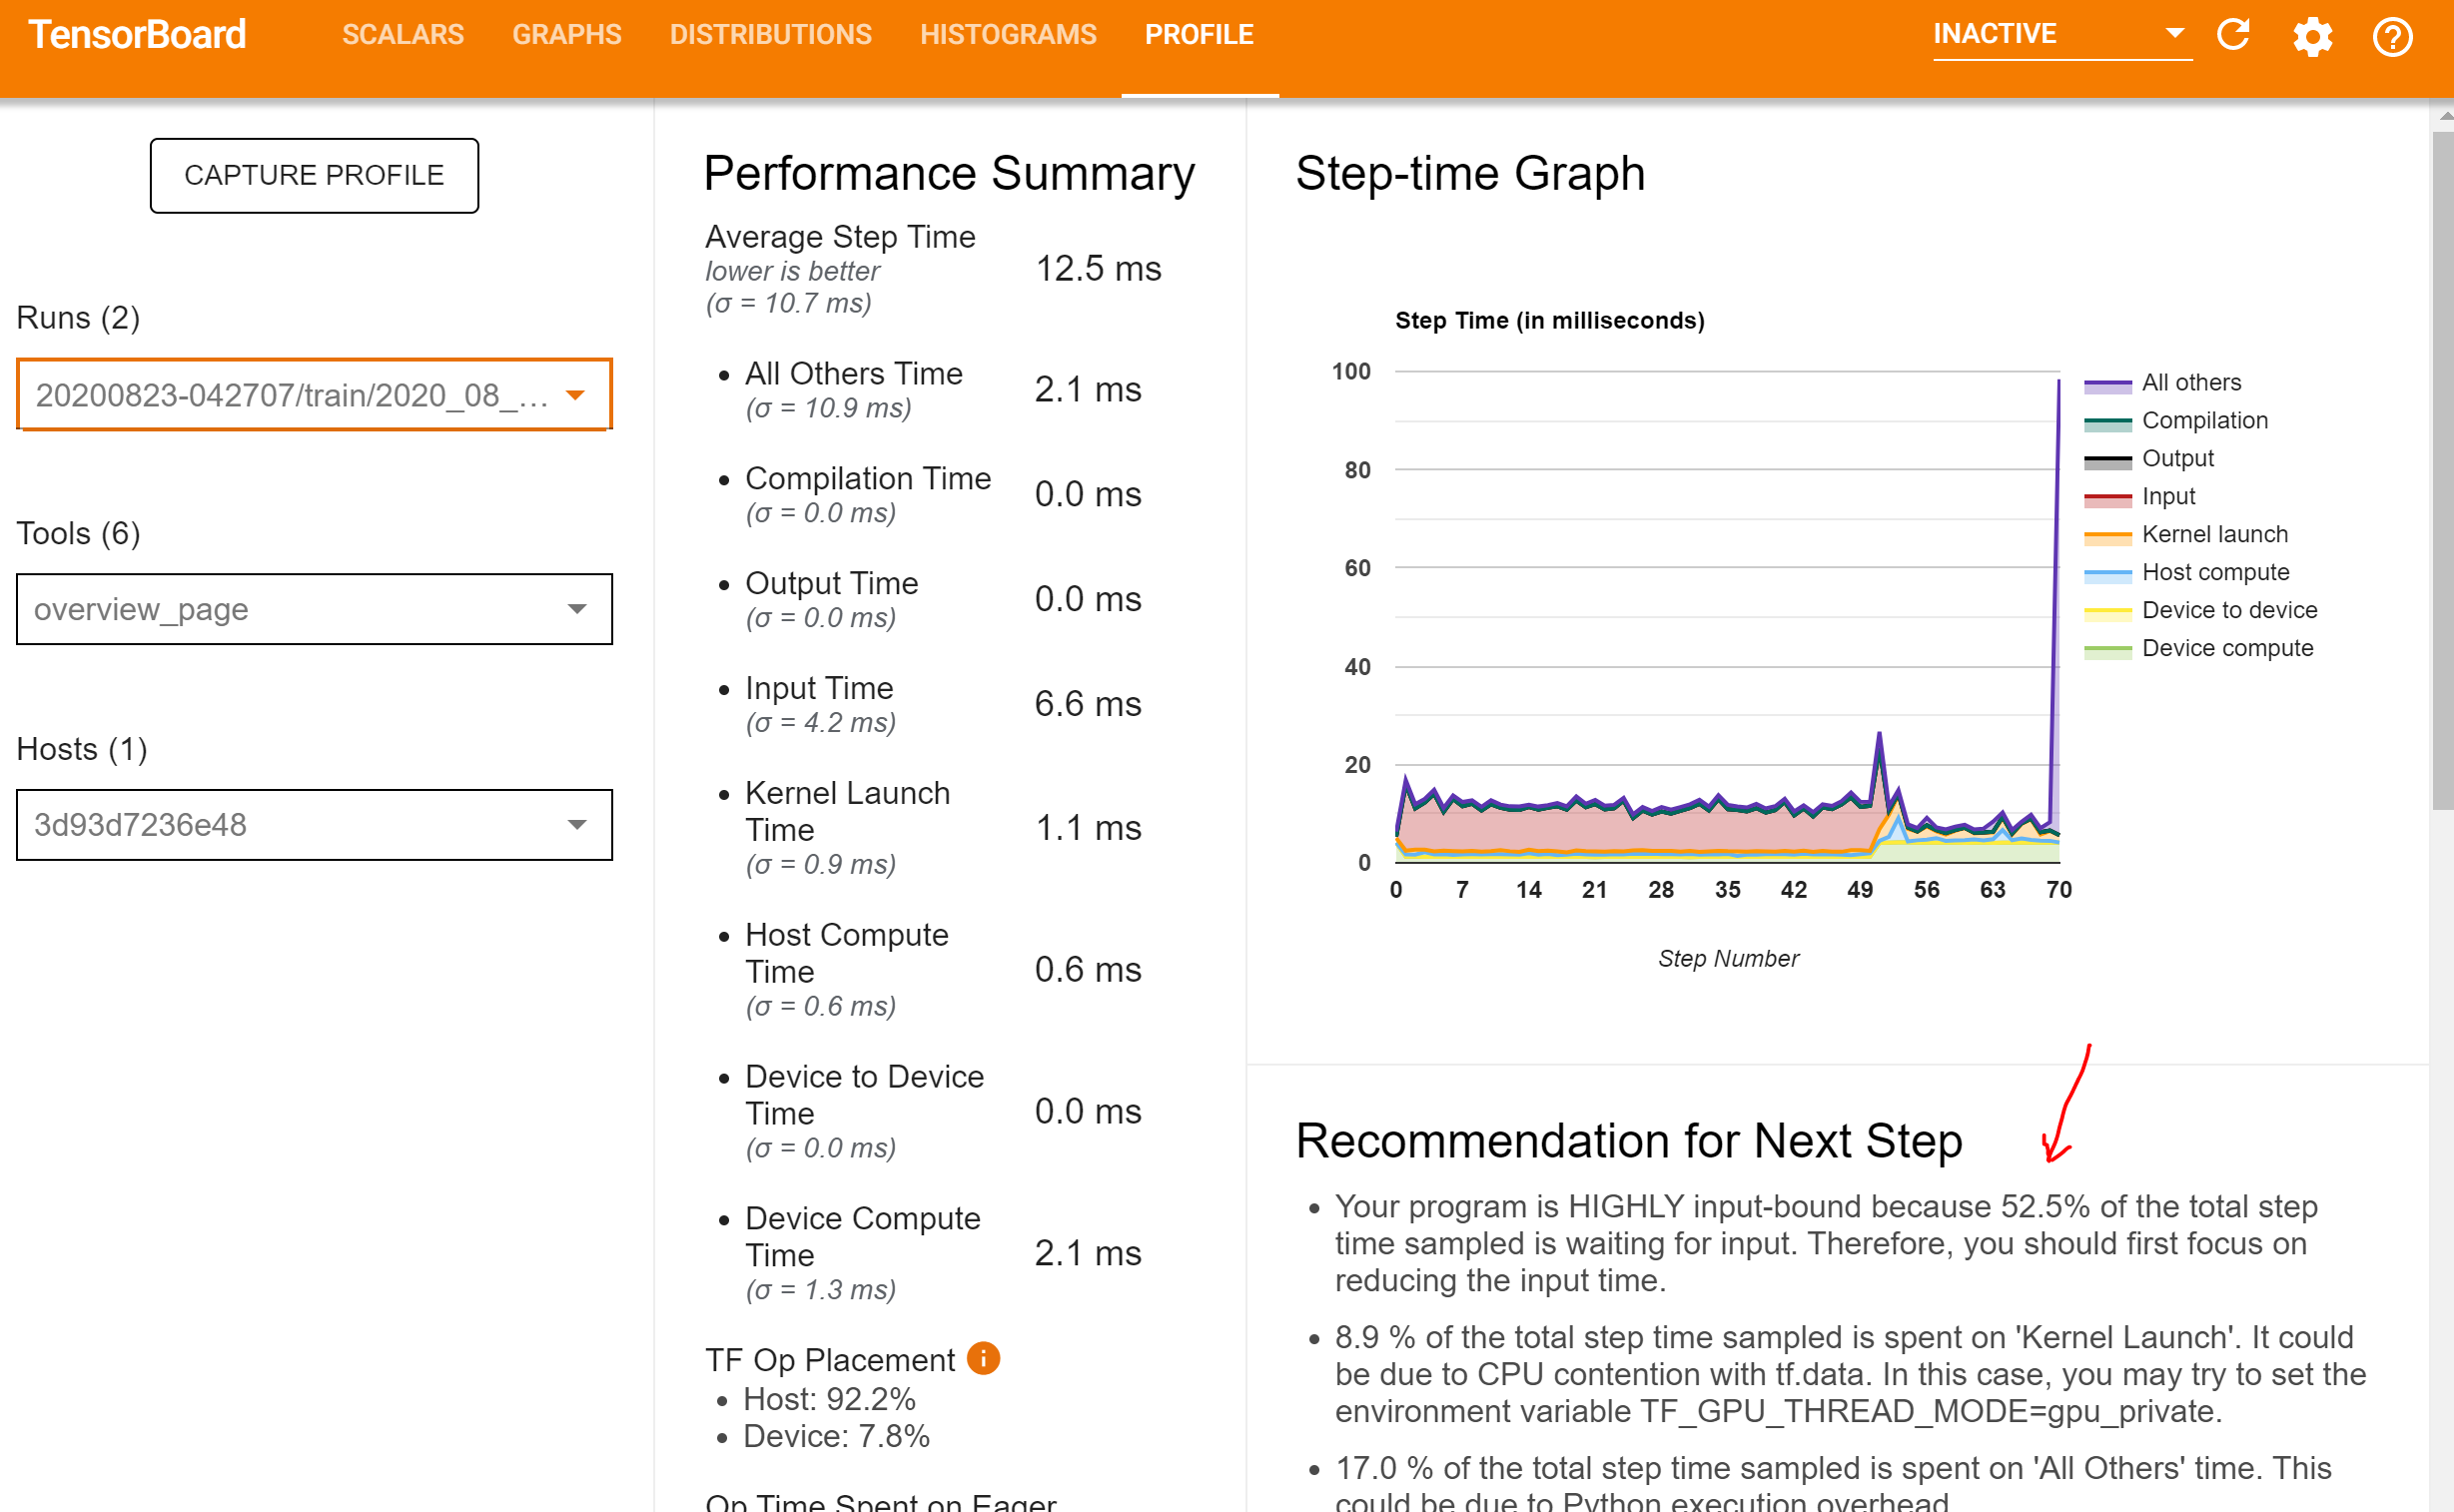

3. We further reduced the batch size to 64 to got about 30%
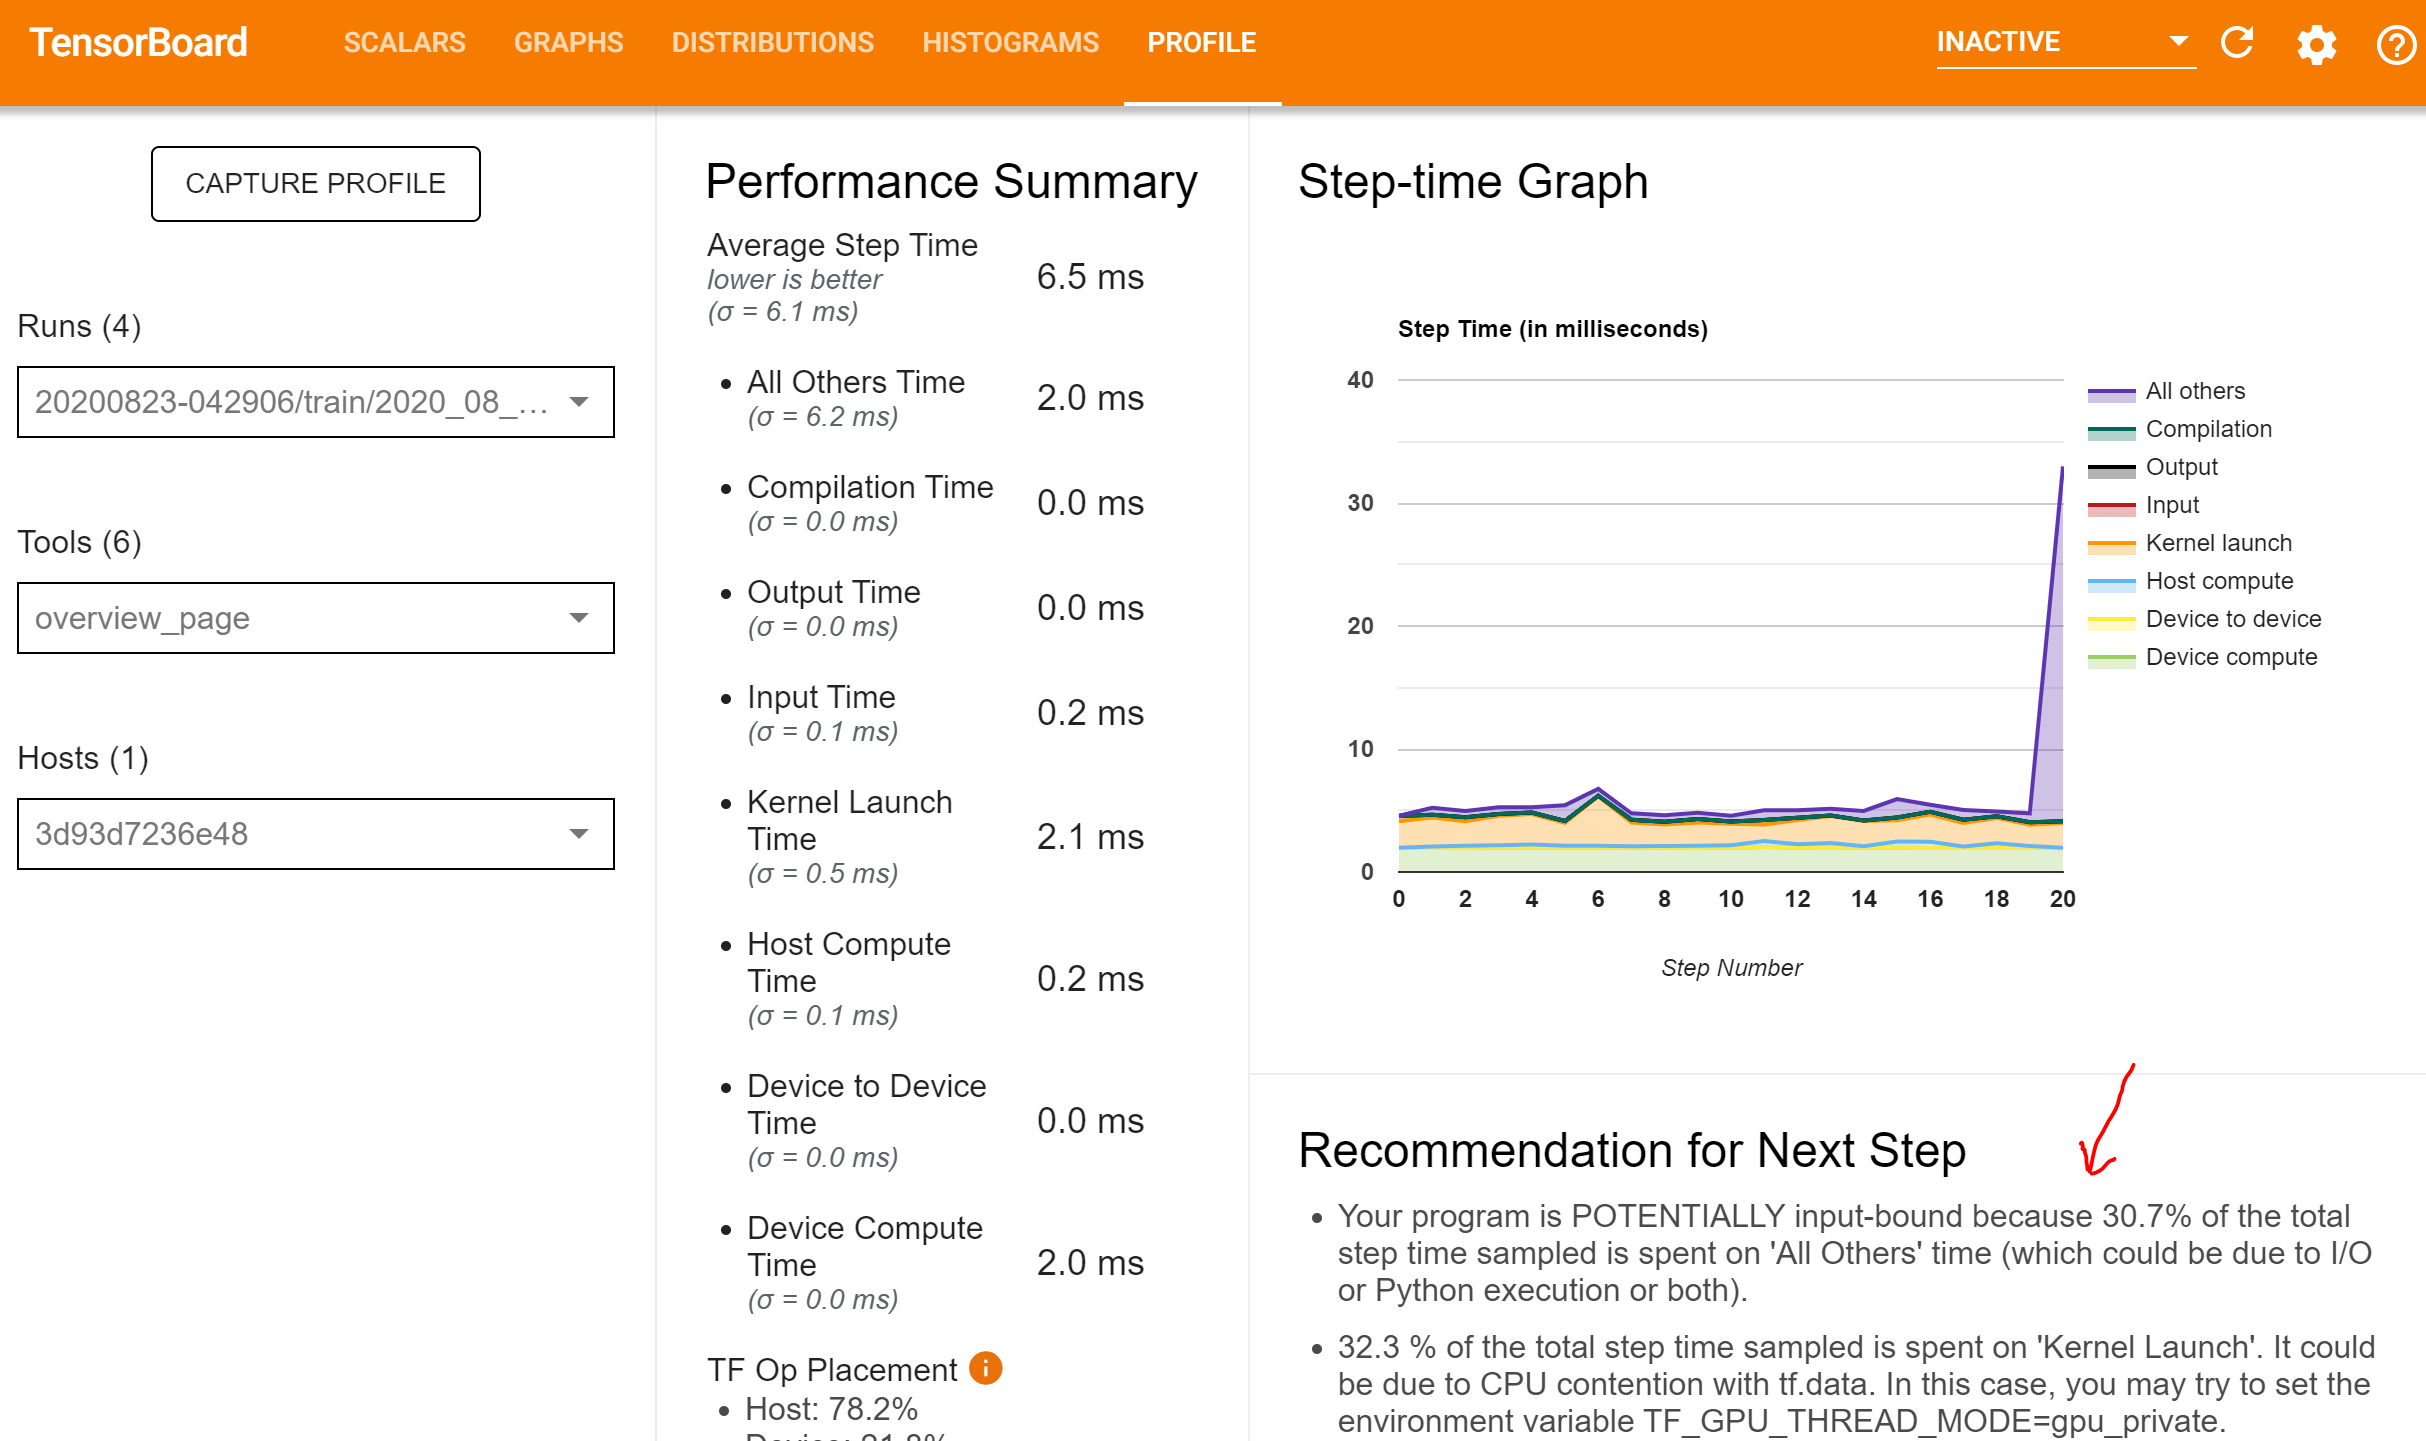

4.  Upon checking the input_pipeline I found that data preprocessing takes most time. So I used some of the suggestions like prefetch in the code.
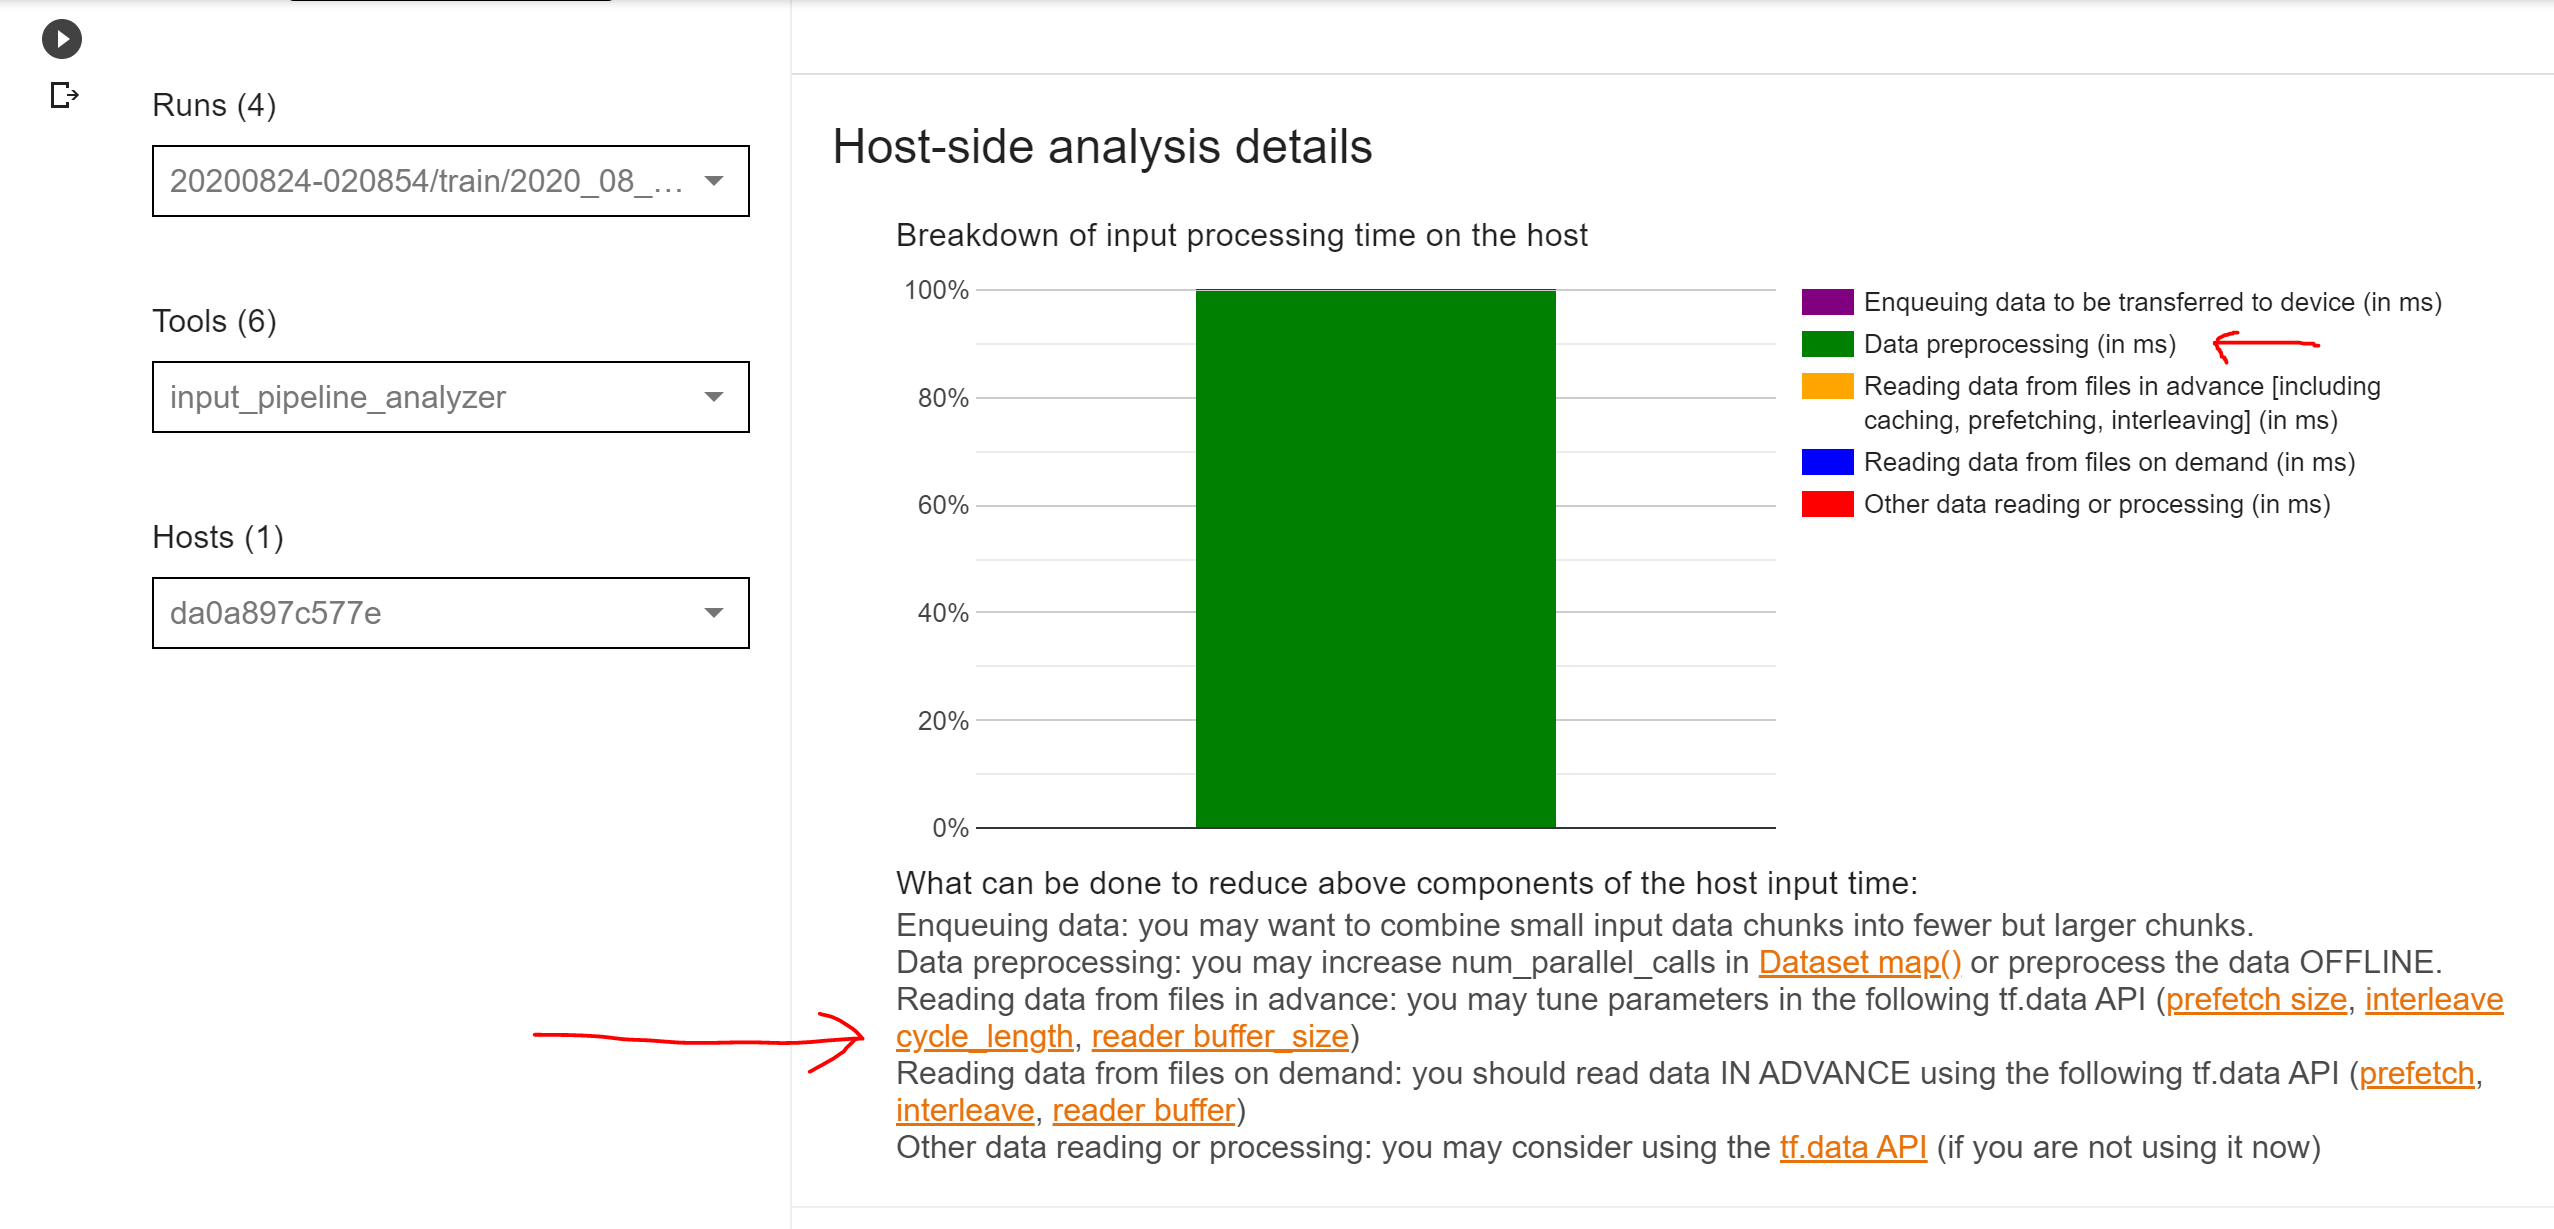

In [ ]:
print("######################### Profiler ###################################")
print("Based on the profiler suggestions I made changes to my code like: ")
print("Using a smaller batch_size, using mutiple extensions from tf.data.Dataset API like cache(), prefetch() and so on.")
print("You can see these changes marked in the comments next to them in my code above.")
print("######################################################################")

### Task 1.4 Fashion-MNIST with transfer learning

*(weight ~2%)*

Use a pretrained model as the convolutional base to improve the classification performance. (Hint: You may use models in Keras Applications or those in the TensorFlow Hub.)

- Try both with fine-tuning and without fine-tuning.
- Report the model performance as before.



In [ ]:
from keras.applications import VGG19

print("We use the pretrained VGG19 model as our convo_base model, which is from keras.applications")
# Create VGG19 base model 
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape = (150, 150, 3), classes = 10)
vgg19.summary()

In [ ]:
print("From the summary above we can see that the VGG19 expects:")
print("1. Input of shape (None, 150, 150, 3)")
print("2. Final layer has shape (None, 4, 4, 512)")
print("So we preprocess the inputs")

# load fashion mnist dataset
(vgg_train_images, vgg_train_labels), (vgg_test_images, vgg_test_labels) = keras.datasets.fashion_mnist.load_data()

# Converts the images to input foramt used by VGG19
def preprocess_image_vgg(image, label):
   image = tf.image.convert_image_dtype(image, tf.float32)  # conver tensor float
   image = image / 255.0 # scale down to 0 to 1 
   image = tf.reshape(image, (1,28*28)) # flatten the image to 1D array
   image = np.dstack([image] * 3) # convert the 1D array image into 3 channels
   #image = tf.stack([image]*3, axis=-1) # convert the 1D array image into 3 channels
   image = image.reshape(-1, 28,28,3) # convert back to shape used in tensorflow with 3 channels
   image = tf.reshape(image,(28,28,3)) # convert back to shape used in tensorflow with 3 channels
   image = tf.image.resize(image, [150,150]) # final shape and size used by VGG19
   return image, label

# augments images for better performance
def image_augmenter_vgg(image, label):
  image = tf.image.random_flip_left_right(image)  # horizontal flip
  #image = tf.image.random_flip_up_down(image) # vertical flip
  #image = tf.image.random_brightness(image,0.2)  
  #image = tf.image.random_contrast(image,0.1,0.9)  
  return image, label

# Split trainin dataset into validation set
print("")
print("We split dataset into train, test and validation:")
vgg_val_dataset_size = 0.16675
vgg_train_images, vgg_val_images = split_data(vgg_train_images, vgg_val_dataset_size)
vgg_train_labels, vgg_val_labels = split_data(vgg_train_labels, vgg_val_dataset_size)

# Apply one hot encoding for the labels
vgg_train_labels_enc = to_categorical(vgg_train_labels)  
vgg_test_labels_enc = to_categorical(vgg_test_labels)
vgg_val_labels_enc = to_categorical(vgg_val_labels)
print("Training dataset length: ", len(vgg_train_images))
print("Training labels length: ", len(vgg_train_labels_enc))
print("Test dataset length: ", len(vgg_test_images))
print("Test labels length: ", len(vgg_test_labels_enc))
print("Validation dataset length: ", len(vgg_val_images))
print("Val labels length: ", len(vgg_val_labels_enc))

# Create input pipeline for efficiency
batch_size = 128
vgg_train_pipe = (tf.data.Dataset.from_tensor_slices((vgg_train_images,vgg_train_labels_enc))
                      .map(preprocess_image_vgg, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                      .map(image_augmenter_vgg, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                      .batch(batch_size) # batch the data so that we do not run out of RAM.
                      .repeat() # repeat so that fit does not run out of data while running a step (depending on batch size)
                      .cache() # cache to improve performance.
                      .prefetch(tf.data.experimental.AUTOTUNE))
vgg_test_pipe = (tf.data.Dataset.from_tensor_slices((vgg_test_images,vgg_test_labels_enc))
                      .map(preprocess_image_vgg, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                      .batch(batch_size))
vgg_val_pipe = (tf.data.Dataset.from_tensor_slices((vgg_val_images,vgg_val_labels_enc))
                      .map(preprocess_image_vgg, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                      .batch(batch_size))

print("")
print("Dataset is preprocessed, encoded for VGG19 and pipelined now. Specs are:") 
print("Train pipe specs:", vgg_train_pipe.element_spec)
print("Val pipe specs:", vgg_val_pipe.element_spec)

In [ ]:
# Extract features
print("We now extract features from VGG19 model for our input data pipeline.")
# Extracting features
with tf.device('/device:GPU:0'):
  vgg_train_features = vgg19.predict(vgg_train_pipe, steps=(len(vgg_train_images)/batch_size), 
                                    verbose=1)
  print("Extracted training features")
  vgg_test_features = vgg19.predict(vgg_test_pipe, steps=(len(vgg_test_images)/batch_size), 
                                 batch_size=batch_size, verbose=1)
  print("Extracted test features")
  vgg_val_features = vgg19.predict(vgg_val_pipe,steps=100,#(len(vgg_val_images)/batch_size), 
                                  batch_size=batch_size, verbose=1)
  print("Extracted validation features")

print("")  
print("Feature extraction from base VGG19 model complete. Shapes are: ")
print("Train features shapes: ", vgg_train_features.shape)
print("Test features shapes: ", vgg_test_features.shape)
print("Val features shapes: ", vgg_val_features.shape)


In [ ]:
# Append a dense layers model to the base vgg19 model
def create_dense_vgg19_model():
  model = models.Sequential()
  model.add(tf.keras.layers.Flatten()) # flatten the inputs from vgg19 base convo model
  # model.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))
  # model.add(layers.LeakyReLU(alpha=0.1))
  model.add(tf.keras.layers.Dense(256, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(layers.Dense(10, activation='softmax'))

  # Compile the model
  model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['accuracy'])
  return model

# Create TensorBoard callback for profiling
!rm -rf ./logs/ # clear old logs
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
vgg_tboard_profiler_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520') # number fo steps to capture
print("Initialized tensor board callback for profiler.")

# Train the the model
print(vgg_train_features.shape)
print(vgg_train_labels_enc.shape)
print(vgg_val_features.shape)
print(vgg_val_labels_enc.shape)
vgg_epochs = 50
dense_vgg19_model = create_dense_vgg19_model()
with tf.device('/device:GPU:0'):
  vgg_history = dense_vgg19_model.fit(
    vgg_train_features,
    vgg_train_labels_enc,
    epochs = vgg_epochs,
    batch_size = batch_size,
    validation_data=(vgg_val_features, vgg_val_labels_enc),
    callbacks=[vgg_tboard_profiler_callback]
  )
print("Training complete.")

# Plot accuracy and loss
print("")
print("Plots to check overfitting or underfitting")
plot_accuracy_loss(vgg_history.history['accuracy'],
                   vgg_history.history['val_accuracy'],
                   vgg_history.history['loss'], 
                   vgg_history.history['val_loss'])
print("")
print("We can observe that the model is a good/robust fit around Epoch = 30 and not underfitted or overfitted.")

### Task 1.5 Performance comparison

*(weight ~2%)*

Record the test accuracy achieved at different training configurations above. Which method achieved the highest accuracy? Why did it work better for this problem?


In [ ]:
print("################## Model performance comparisons for Test Accuracy #############################")
print("We noted the following best test accuracies from our models so far.")
print("Task 1.1. Assignment 1 model's best accuracy        : ", fm_best_accuracy_result['Test Accuracy'].iloc[0])
print("Task 1.2. Convo2D network's best accuracy           : ", fm_best_accuracy_result_convo['Test Accuracy'].iloc[0])
print("Task 1.3. Convo2D with augmentation's best accuracy : ", fm_aug_acc)
print("Task 1.4. Transfer learning model's best accuracy   : ", fm_best_accuracy_result_transferlearn['Test Accuracy'].iloc[0])
print("################################################################################################")

print("")
print("Thus the model that performed best is: TODO")
print("This was mainly because: TODO")
print("")
print("Convo2D gave good accuracy of 92% initially but it reduced to 89% after image augmentation with same number of epochs.")
print("This was mainly because the model with augmentation seems to but underfitted as seen from plots.")
print("So if we increase the number of epochs we might get a better fitting model.")

## Task 2 Fast training of deep networks

*(weight ~15%)*

### Task 2.1 Train a highly accurate network for CIFAR10

*(weight ~4%)*

In this task, you will train deep neural networks on the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). Compared with the datasets that you have worked on so far, CIFAR10 represents a relatively larger multi-class classification problem and presents a great opportunity for you to solve a "harder" problem.



#### Task 2.1.1 Document the hardware used

Before you start, write down your hardware specifications, including 

- the GPU model, the number of GPUs, and the GPU memory
- the CPU model, the number of CPUs, and the CPU clock speed

(Hint: you may find commands like `nvidia-smi`, `lscpu` or `psutil` useful.)

#### Task 2.1.2 Train a "shallow" ConvNet

Build a ConvNet with fewer than 10 layers. Train the network until it converges. You will use this network as a baseline for the later experiments. 

- Plot the training and validation history. 
- Report the testing accuracy. 

#### Task 2.1.3 Train a ResNet

Train a residual neural network (ResNet) on the CIFAR10 training data and report the test accuracy and the training time.

The ResNet is a popular network architecture for image classification. You may find more information about how ResNet works by reading this [paper](https://arxiv.org/abs/1512.03385).


*(You may implement a resnet model or use an existing implementation. In either case, you should not use pretrained network weights.)*

### Task 2.2 Fast training of ResNet

*(weight ~8%)*

In this task, you will experiment with different ways to reduce the time for training your ResNet on CIFAR10. There are different ways to speed up neural network training; below are two ideas. Please select at least one idea to implement. Explain the experiment steps and report the final performance and training time.

#### Option 1. Learning rate schedule

Use a learning rate schedule for the training. Some popular learning rate schedules include 

- the Step Decay learning rate (e.g., see [here](https://github.com/kuangliu/pytorch-cifar))
- [Cyclical learning rates](https://arxiv.org/abs/1506.01186)
- [The exponential learning rate](https://openreview.net/forum?id=rJg8TeSFDH) 

Also Keras provides [some convenient functions](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules) that you can use.


#### Option 2. Look ahead optimiser

Read [this paper](https://arxiv.org/abs/1907.08610) and implement the Lookahead optimiser.

### Task 2.3 Performance comparison

*(weight ~3%)*

Based on the above experiments, which method or which combination of methods result in the best accuracy with the same training time.

## Task 3 Design a novel deep neural network model (Challenge Task for Targeting HD Grades)

*(weight ~20%)*
Here, you have to show your critical idea to design a new neural network model. We will evaluate your results based on the novelty of the model and performance of the model. 

### Task 3.1: The key idea to design a novel deep neural networks for CIFAR10

*(weight ~10%)*

In this task, you will design a novel deep neural networks on the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 represents a relatively larger multi-class classification problem and presents a great opportunity for you to solve a "harder" problem. Different from Task 2, in this task you are required to design a novel neural network and optimize the performance in classification. In your answer, you have to clearly present what the key difference between your model and the classic ones, what the benefits in your design model.

### Task 3.2: The implementation of the novel deep neural networks for CIFAR10

*(weight ~10%)*

In this task, it requires you to write the codes for model implementation and report the performance. In your results, you have to demonstrate the compared performance of your new model and the state-of-the-art models.

---
**END OF ASSIGNMENT TWO**